In [ ]:
# Datasets and Parquet

**TOC:**

1. Reading and writing Parquet
2. Resampling 15min data

## 1. Reading and writing Parquet

**Context: PRO and CON of Parquet** 

**PRO:**<BR>
- saves data types, not like csv where everything is a string
- compression results in 2 upto 10 times smaller  than csv
- faster: Parquet store data in columns rather than rows, enabling selective reading only relevant data.

**CON:**<BR>
- Not human readable

In [8]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import pyarrow
import matplotlib.pyplot as plt

print(f'Python version: {sys.version}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'pyarrow version: {pyarrow.__version__}')

Python version: 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:34:54) [Clang 16.0.6 ]
pandas version: 2.2.2
numpy version: 1.26.4
pyarrow version: 17.0.0


In [4]:
# Step 0: Define the paths
file_path_read = 'https://raw.githubusercontent.com/tribp/Forecasting/main/datasets/Elia/ods001.parquet'
file_path_save ='Elia_2015-2024.parquet'

# Step 1: Load the Parquet file into a DataFrame
df = pd.read_parquet(file_path_read)
df.head(2)

,datetime,resolutioncode,totalload,mostrecentforecast,mostrecentconfidence10,mostrecentconfidence90,dayaheadforecast,dayaheadconfidence10,dayaheadconfidence90,weekaheadforecast
0,2025-01-27 23:45:00+01:00,PT15M,NaN,9592.2,9180.97,10003.43,9592.2,9180.97,10003.43,9592.2
1,2025-01-27 23:30:00+01:00,PT15M,NaN,9642.1,9228.73,10055.47,9642.1,9228.73,10055.47,9642.1


In [ ]:
# Step 2: Ensure the 'Datetime' column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Step 3: Filter the DataFrame for rows until 1st January 2025
df_filtered = df[df['datetime'] < '2025-01-01']

# Step 4: Reset the index of the DataFrame
df_filtered.reset_index(drop=True, inplace=True)

# Step 5: Save the filtered DataFrame back to a new Parquet file
df_filtered.to_parquet(file_path_save)
df_filtered.head(3)

## 1.2 Read and check parquet file

In [16]:
df = pd.read_parquet(file_path_save)
df.head(3)

<bound method NDFrame.head of                         datetime resolutioncode  totalload  \
0      2024-12-31 23:45:00+01:00          PT15M    8593.73   
1      2024-12-31 23:30:00+01:00          PT15M    8697.44   
2      2024-12-31 23:15:00+01:00          PT15M    8774.47   
3      2024-12-31 23:00:00+01:00          PT15M    8858.48   
4      2024-12-31 22:45:00+01:00          PT15M    8861.50   
...                          ...            ...        ...   
350683 2015-01-01 01:00:00+01:00          PT15M    9755.00   
350684 2015-01-01 00:45:00+01:00          PT15M    9821.78   
350685 2015-01-01 00:30:00+01:00          PT15M    9952.87   
350686 2015-01-01 00:15:00+01:00          PT15M   10051.28   
350687 2015-01-01 00:00:00+01:00          PT15M   10142.19   

        mostrecentforecast  mostrecentconfidence10  mostrecentconfidence90  \
0                  8258.90                 8015.84                 8501.96   
1                  8364.12                 8117.97                 86

In [17]:
print(df.dtypes)

datetime                  datetime64[ms, Europe/Brussels]
resolutioncode                                     object
totalload                                         float64
mostrecentforecast                                float64
mostrecentconfidence10                            float64
mostrecentconfidence90                            float64
dayaheadforecast                                  float64
dayaheadconfidence10                              float64
dayaheadconfidence90                              float64
weekaheadforecast                                 float64
dtype: object
datetime                  datetime64[ms, Europe/Brussels]
resolutioncode                                     object
totalload                                         float64
mostrecentforecast                                float64
mostrecentconfidence10                            float64
mostrecentconfidence90                            float64
dayaheadforecast                                  float64


# 2. Resampling 15min data

## 2.1 We need a new file that contains all daily maxima of the 15min values

In [4]:
# Step 0: Define the paths
file_path_read = 'https://raw.githubusercontent.com/tribp/Forecasting/main/datasets/Elia/Elia_2015-2024.parquet'
file_path_save ='Elia_2015-2024_daily_max.parquet'

# Step 1: Load the Parquet file into a DataFramed
df_daily_max = pd.read_parquet(file_path_read)
#print(df_monthly.head(2))

# Step 2: Set the 'datetime' column as the index
df_daily_max.set_index('datetime', inplace=True)

# Step 3: delete all columns except 'datetime'(Index), 'totalload' and mostrecentforecast'
df_daily_max = df_daily_max[['totalload', 'mostrecentforecast', 'dayaheadforecast', 'weekaheadforecast']]

# Step 4: Resample the DataFrame to a daily frequency that holds the daily maximum
df_daily_max = df_daily_max.resample('D').max()
df_daily_max.head(2)

# Step 5: Save the resampled DataFrame back to a new Parquet file
df_daily_max.to_parquet(file_path_save)





## 2.2 Read and check daily maxima file

In [3]:
# Step 0: Define the paths
file_path_read = 'https://raw.githubusercontent.com/tribp/Forecasting/main/datasets/Elia/Elia_2015-2024_daily_max.parquet'

# Step 1: Load the Parquet file into a DataFramed
df_daily_max = pd.read_parquet(file_path_read)
df_daily_max.head(2)

,totalload,mostrecentforecast
datetime,,
2015-01-01 00:00:00+01:00,10211.6,9496.05
2015-01-02 00:00:00+01:00,11501.8,10597.84


# 3. Extending the holiday dict from the holiday library

In [22]:
import holidays
import json
import requests
from datetime import datetime

In [23]:
# Step 1: Load the Belgium holidays
be_holidays = holidays.Belgium()

# step 2: Load the school holidays from the file
file_path = 'https://raw.githubusercontent.com/tribp/Forecasting/main/datasets/holidays/schoolvakanties.json'

response = requests.get(file_path)
school_holidays = response.json()

# step 3: Extend the be_holidays dictionary with the school holidays
for year, holidays_dict in school_holidays.items():
    for date_str, holiday_name in holidays_dict.items():
        date_obj = datetime.strptime(date_str, '%Y-%m-%d').date()
        be_holidays[date_obj] = holiday_name

## 3. stationarity

In [29]:
np.random.seed(50)
time = np.arange(1,101)

# stationary time series
stationary = np.random.normal(0, 1, 100)

# trend 
trend = 0.5 * time + np.random.normal(0, 1, 100)

# seasonal 
seasonality = 10 + 10*np.sin(time) + np.random.normal(0, 1, 100)

# trend_seasonal
trend_seasonal = trend + seasonality

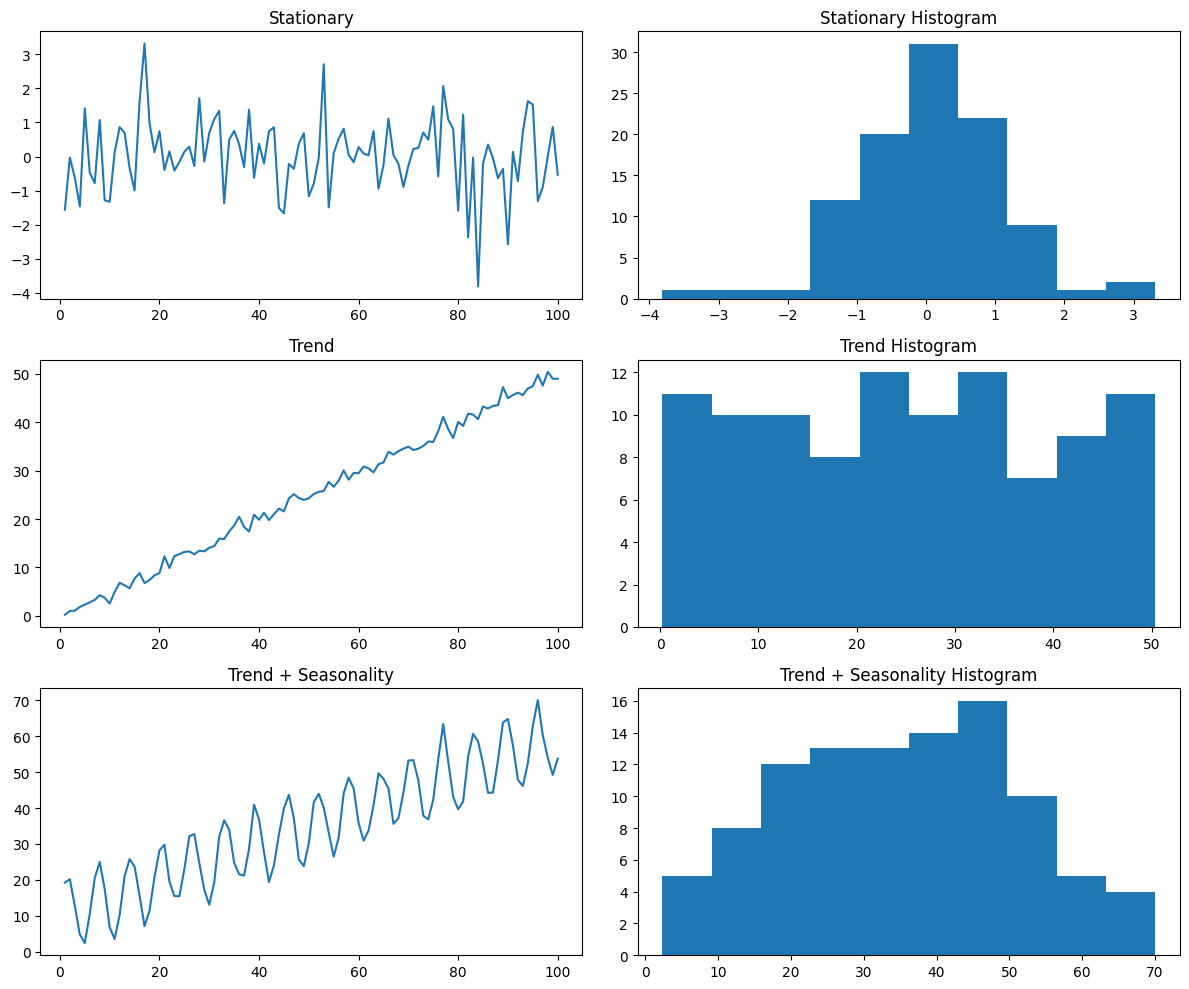

In [30]:

fig, ax = plt.subplots(3, 2, figsize=(12, 10))
ax[0, 0].plot(time, stationary)
ax[0, 0].set_title('Stationary')
ax[0, 1].hist(pd.Series(stationary))
ax[0, 1].set_title('Stationary Histogram')
ax[1, 0].plot(time, trend)
ax[1, 0].set_title('Trend')
ax[1, 1].hist(pd.Series(trend))
ax[1, 1].set_title('Trend Histogram')
ax[2, 0].plot(time, trend_seasonal)
ax[2, 0].set_title('Trend + Seasonality')
ax[2, 1].hist(pd.Series(trend_seasonal))
ax[2, 1].set_title('Trend + Seasonality Histogram')
plt.tight_layout()
plt.show()

In [37]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dicky Fuller test: p-value must be < 0.05 to be stationary
test_stationarity = adfuller(trend_seasonal)
print('p-value: %f' % test_stationarity[1])
print(f'Time series is {"not " if test_stationarity[1] > 0.05 else ""}stationary')

p-value: 0.904626
Time series is not stationary
